# __Desafío - Naive Bayes__
## Descripción
<ul>
<li>En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de
distintos artistas. Cada uno de los <code>csv</code> se encuentra en la carpeta <code>dump</code> dentro del
proyecto.</li>
<li>Cada <code>csv</code> tiene el nombre del artista a analizar. Los archivos contienen el nombre del
artista, el género musical del artista, el nombre de la canción y las letras.</li>
<li>En base a esta información, se les pide un modelo generativo que pueda predecir el
género de una canción a partir de la letra de una canción.</li>
<li>Existen 4 géneros que se registran en la base de datos, por lo que para esta actividad
trabajaremos con un Multinomial Naive Bayes.</li>
</ul>


## Ejercicio 1: Preparar el ambiente de trabajo
<ul>
<li>Importe los módulos <code>numpy</code>, <code>pandas</code>, <code>matplotlib</code>, <code>seaborn</code>, <code>glob</code> y <code>os</code> siguiendo las
buenas prácticas. Los últimos dos módulos permitirán realizar la importación de
múltiples archivos dentro de la carpeta <code>dump</code>.</li>
<li>Para ello genere un objeto que guarde en una lista todos los archivos alojados en <code>dump</code>
utilizando <code>glob.glob</code> y <code>os.getcwd()</code> para extraer las rutas absolutas. Posteriormente
genere un objeto <code>pd.DataFrame</code> que contenga todos los <code>csv</code>.</li>
<li>Asegúrese de eliminar la columna <code>Unnamed: 0</code> que se genera por defecto.</li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [16]:
paths = glob.glob(os.getcwd() + '/dump/*.csv')
baseDf = pd.DataFrame()
for path in paths:
    artistDf = pd.read_csv(path).drop(columns=['Unnamed: 0'])
    baseDf = pd.concat([baseDf, artistDf])
baseDf.sample()

,0,1,2,3
56,A Tribe Called Quest,hiphop,Stressed Out,Intro./chorus \n Faith Evans: \n I really know...


## Ejercicio 2: Descripción de los datos
<ul>
<li>Utilizando el objeto creado en el Ejercicio 1, genere dos gráficos de barras que resuman
la siguiente información:
<ul>
<li>La cantidad de canciones registradas por cada artista, ordenados de mayor a
menor.</li>
<li>La cantidad de canciones registradas en cada género, ordenados de mayor a
menor.</li></ul></li>
<li>Comente sobre las principales tendencias.</li>
</ul>


Text(0.5, 1.0, 'Cantidad de canciones según género')

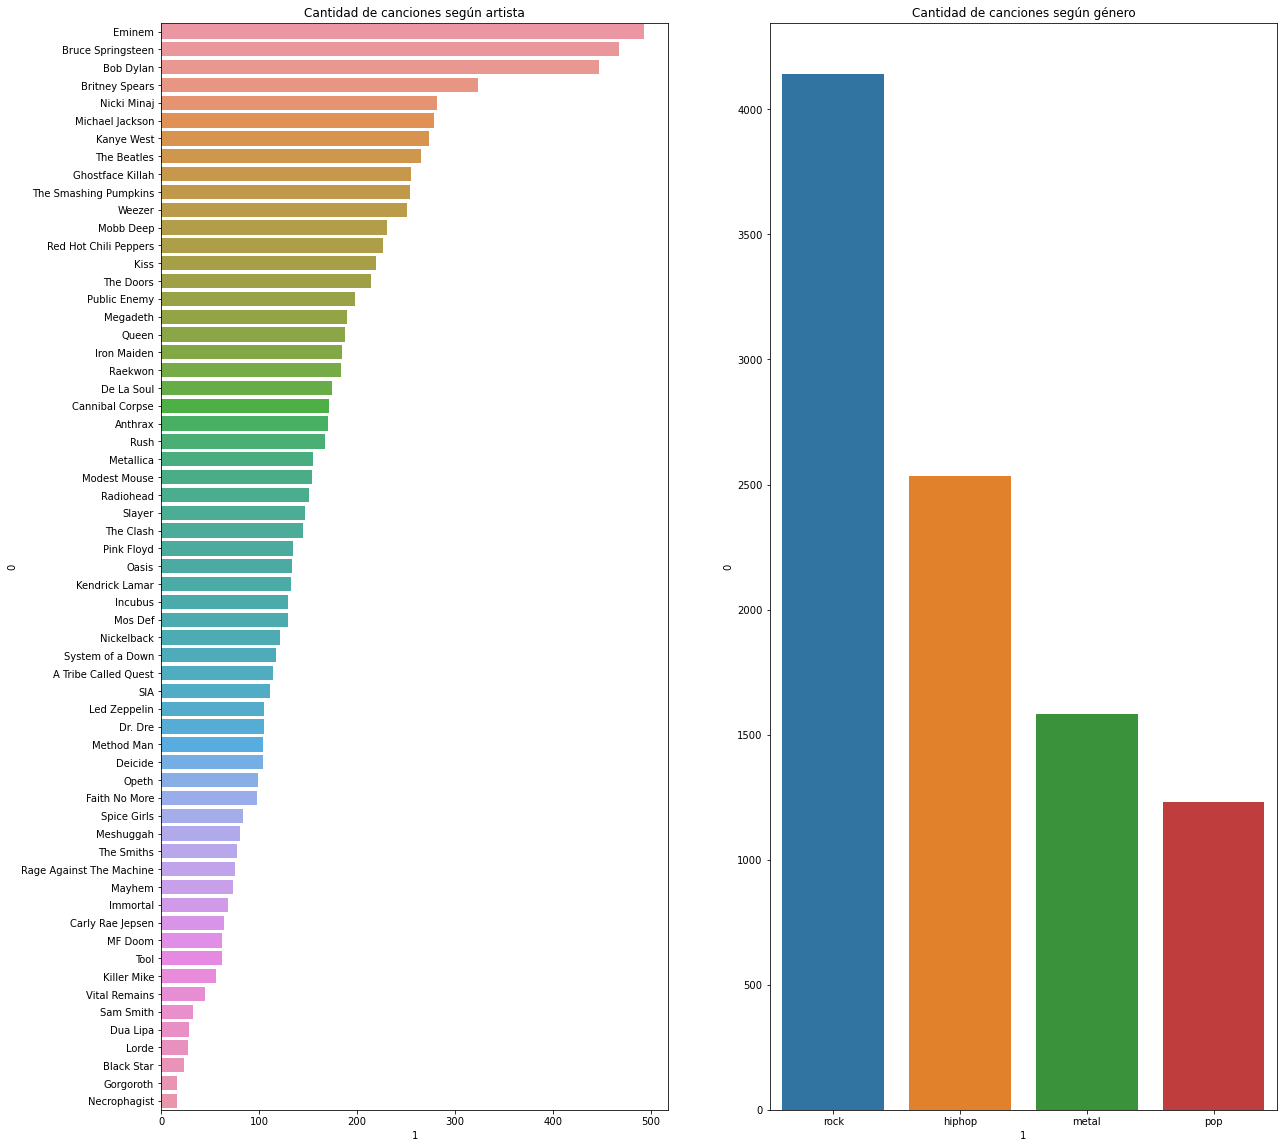

In [51]:
# Generamos los grupos
artistMetrics = baseDf.groupby('0').count().sort_values('1', ascending=False)
genreMetrics = baseDf.groupby('1').count().sort_values('2', ascending=False)
# Generamos los Gráficos
fig, ax= plt.subplots(1,2, figsize=(20, 20))
fig.set_label('Jjaajaj')
# Gráfico para agrupación según artista
sns.barplot(y=artistMetrics.index, x=artistMetrics['1'], ax=ax[0])
ax[0].set_title('Cantidad de canciones según artista')
# Gráfico para agrupación según género
sns.barplot(x=genreMetrics.index, y=genreMetrics['0'], ax=ax[1])
ax[1].set_title('Cantidad de canciones según género')

Vemos que hay muchos artistas distintos, lo que complejiza bastante el encoding de esas variables categóricas. Por otro lado, vemos que los generos están desbalanceados, lo que hace mas dificil para el modelo predecir todas las clases con la misma eficacia.

## Ejercicio 3: Matriz de ocurrencias
### Digresión: Tokenización de Textos
Para poder trabajar con textos, debemos pasarlos a una __matriz dispersa__, donde cada fila
representará una entrada (en este caso, una canción), y cada columna __representará una
palabra (token)__. Este es el proceso de tokenización: Identificar la ocurrencia de una palabra
específica dentro de un conjunto de textos (corpus).
<br>

El tokenizador más simple <code>sklearn.feature_extraction.text.CountVectorizer</code> genera
una colección de textos a una matriz que representa la frecuencia __dentro del texto__ de una
palabra específica.
El tokenizador funciona de la siguiente manera:

```python
from sklearn.feature_extraction.text import CountVectorizer
# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words='english')
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(lista_de_textos)
# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)
```
<ul>
<li>Importe la clase <code>CountVectorizer</code> dentro de los módulos <code>feature_extraction.text</code>
de la librería <code>sklearn</code>. Lea la documentación asociada a ésta. ¿Cuál es el objetivo de
esta clase?</li>
<li>Aplique la clase para extraer las 100 palabras más repetidas en toda la base de datos.</li>
<li>Genere una función que replique el procedimiento para cada uno de los géneros.</li>
<li>Comente sobre las principales características de cada género en cuanto a sus palabras.</li>
</ul>


## Ejercicio 4: Entrenamiento del Modelo
### Digresión: <code>sklearn</code> Pipelines
La clase <code>Pipeline</code> del módulo <code>sklearn.pipeline</code> permite concatenar múltiples pasos de
procesamiento y preprocesamiento en un estimador generado por algún método de
<code>scikit-learn</code>. En sí, la clase cuenta con los métodos clásicos <code>fit</code>, <code>predict</code> y <code>score</code> y
presenta un comportamiento idéntico a los demás objetos de <code>scikit-learn</code>. Uno de los usos
más comunes es para concatenar pasos de preprocesamiento con un modelo.
### Componentes de un <code>Pipeline</code>
Imaginemos que deseamos implementar el siguiente modelo. Considerando un conjunto de
datos, deseo __Estandarizar__, posteriormente __extraer sus principales componentes__ y finalmente
aplicar un modelo de __regresión lineal__. Este flujo se puede reexpresar como:
```python
pipeline_model = Pipeline([('scale', StandardScaler()),
    ('pca', RandomizedPCA(n_components=3)),
    ('model', LinearRegression())])
```
Algunos de los elementos a considerar:
<ol>
<li>Cada paso se considera como una tupla, donde se declara el nombre del paso y la
función a implementar. En este caso, nuestro primer paso es estandarizar la matriz, por
lo que asociamos el método <code>StandardScaler</code> con el string <code>scale</code>.</li>
<li>Todos los pasos declarados se incorporan en una lista, donde el orden de ingreso
representa el orden de ejecución.</li>
<ol>
